## Chargement des données

In [7]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz


--2024-12-10 08:02:28--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  25.9MB/s    in 6.4s    

2024-12-10 08:02:35 (25.2 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


## Préparation des données

### Étapes :
1. Chargement des données CIFAR-100.
2. Normalisation des pixels (0-255 → 0-1).
3. Aplatissement des images pour compatibilité avec Random Forest.



In [8]:
import pickle

# Charger les données d'entraînement
with open("cifar-100-python/train", "rb") as f:
    train_data = pickle.load(f, encoding="latin1")

# Charger les données de test
with open("cifar-100-python/test", "rb") as f:
    test_data = pickle.load(f, encoding="latin1")

# Vérifier les clés des données
print(train_data.keys())  # Doit afficher 'data', 'fine_labels', etc.


dict_keys(['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data'])


In [9]:
# Extraire les images
X_train = train_data['data'] / 255.0  # Images d'entraînement
X_test = test_data['data'] / 255.0    # Images de test

# Extraire les labels
y_train = train_data['fine_labels']
y_test = test_data['fine_labels']

X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Aplatir les images d'entraînement
X_test_flat = X_test.reshape(X_test.shape[0], -1)    # Aplatir les images de test

## Modèle de base

### Description :
- Utilisation du modèle Random Forest avec des hyperparamètres par défaut :
  - **`n_estimators=100`** : Nombre d'arbres.
  - **`max_depth=None`** : Arbres sans limite de profondeur.
  - **`min_samples_split=2`** : Division d'un nœud si au moins 2 échantillons.

### Résultat :
- **Précision sur le jeu de test :** 22%
- Analyse des performances avec une matrice de confusion.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialiser Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Entraîner le modèle
rf.fit(X_train_flat, y_train)

# Prédire sur les données de test
y_pred = rf.predict(X_test_flat)

# Évaluer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.2256


In [7]:
from sklearn.model_selection import GridSearchCV

# Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [100, 200, 300],  # Nombre d'arbres
    'max_depth': [10, 20, None],      # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10], # Minimum d'échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],   # Minimum d'échantillons par feuille
    'bootstrap': [True, False]       # Méthode d'échantillonnage
}


## Optimisation des Hyperparamètres

### Hyperparamètres testés avec Grid Search :
1. **`n_estimators`** : [50, 100, 200]
2. **`max_depth`** : [10, None]
3. **`min_samples_split`** : [2, 5]
4. **`min_samples_leaf`** : [1]
5. **`bootstrap`** : [True]

### Résultat :
- **Précision optimisée :** 25%
- Analyse des performances après optimisation.


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Grille ultra-réduite
param_grid = {
    'n_estimators': [50, 100, 200],  # Testez 3 valeurs
    'max_depth': [10, None],          # Fixez une profondeur
    'min_samples_split': [2,5],   # Deux options
    'min_samples_leaf': [1],    # Une seule option
    'bootstrap': [True]         # Fixez à True
}

# Modèle Random Forest
rf = RandomForestClassifier(random_state=42)

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2,  # Validation croisée minimale
    verbose=2,
    n_jobs=-1
)

# Exécution
grid_search.fit(X_train_flat, y_train)

# Résultats
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.1664


In [9]:
# Afficher les meilleurs hyperparamètres et leur score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")


Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.16638


## Évaluation des Performances

### 1. Matrice de Confusion
- Montre les classes correctement identifiées et celles souvent confondues.

### 2. Courbe ROC
- **AUC micro-moyenne :** 0.7959
- La courbe ROC met en évidence une capacité correcte à distinguer les classes.

### 3. Observations :
- Random Forest est limité pour capturer les relations spatiales dans les images.
- Performances respectables pour un modèle adapté aux données tabulaires.


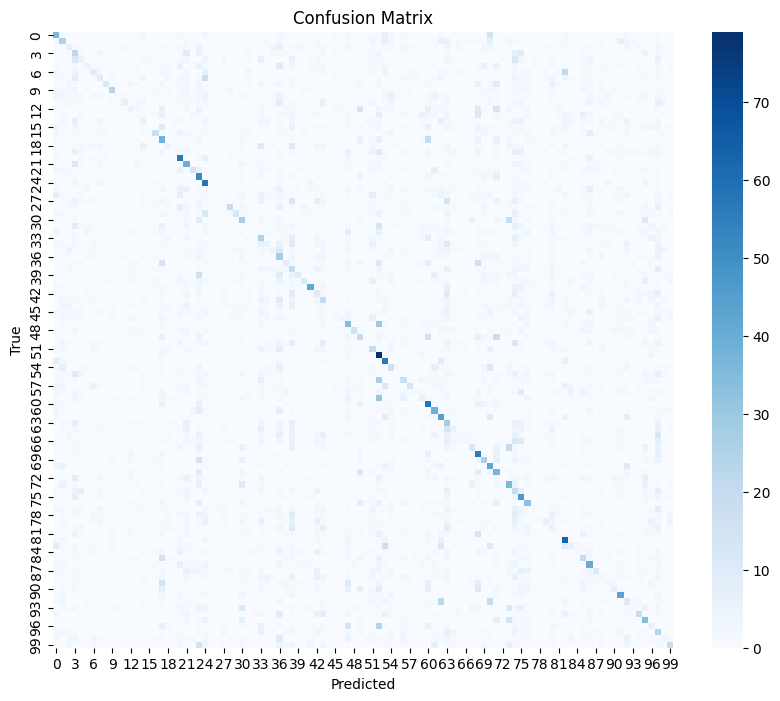

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_test_pred)

# Visualisation de la matrice
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Étape 1 : Entraîner le modèle Random Forest
rf.fit(X_train_flat, y_train)

# Étape 2 : Prédire les probabilités pour chaque classe
y_pred_proba = rf.predict_proba(X_test_flat)

# Étape 3 : Convertir y_test en format one-hot
y_test_onehot = label_binarize(y_test, classes=list(range(100)))

# Étape 4 : Calculer l'AUC pour les classes multiples
auc = roc_auc_score(y_test_onehot, y_pred_proba, multi_class='ovr')
print(f"Multiclass AUC: {auc:.4f}")


Multiclass AUC: 0.7959


X_train shape: (50000, 3072), y_train length: 50000
X_test shape: (10000, 3072), y_test length: 10000


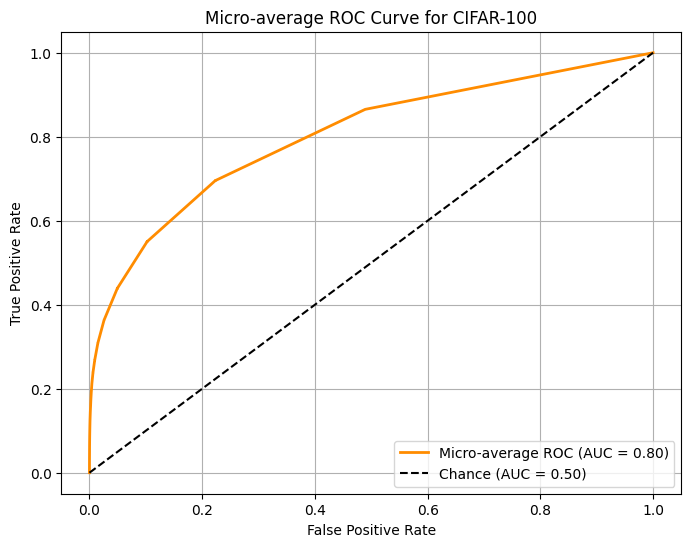

In [11]:
# Importations nécessaires
import pickle
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Étape 1 : Chargement des données CIFAR-100
# Assurez-vous que ces fichiers existent dans votre environnement
with open("cifar-100-python/train", "rb") as f:
    train_data = pickle.load(f, encoding="latin1")
with open("cifar-100-python/test", "rb") as f:
    test_data = pickle.load(f, encoding="latin1")

# Normalisation des images
X_train = train_data['data'] / 255.0
X_test = test_data['data'] / 255.0

# Aplatir les images pour Random Forest
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Labels (y_train et y_test)
y_train = train_data['fine_labels']  # Labels d'entraînement
y_test = test_data['fine_labels']    # Labels de test

# Vérification des données
print(f"X_train shape: {X_train_flat.shape}, y_train length: {len(y_train)}")
print(f"X_test shape: {X_test_flat.shape}, y_test length: {len(y_test)}")

# Étape 2 : Entraîner un modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)

# Prédire les probabilités pour le jeu de test
y_pred_proba = rf.predict_proba(X_test_flat)

# Étape 3 : Convertir les labels en one-hot encoding
y_test_onehot = label_binarize(y_test, classes=list(range(100)))  # 100 classes pour CIFAR-100

# Étape 4 : Calcul de la courbe ROC micro-moyenne
fpr_micro, tpr_micro, _ = roc_curve(y_test_onehot.ravel(), y_pred_proba.ravel())  # FPR et TPR
roc_auc_micro = auc(fpr_micro, tpr_micro)  # AUC micro-moyenne

# Étape 5 : Tracer la courbe ROC moyenne
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})", color='darkorange', lw=2)

# Ajouter une ligne de base
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")

# Ajouter les étiquettes et le titre
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve for CIFAR-100')
plt.legend(loc="lower right")
plt.grid()
plt.show()


## Conclusion

- **Précision finale :** 25%.
- **AUC micro-moyenne :** 0.7959.
- Random Forest offre une bonne baseline pour ce projet, mais ses limites sont apparentes sur des données visuelles.

